#### reference: https://nbviewer.jupyter.org/github/YunYang1994/tensorflow-yolov3/blob/master/docs/Box-Clustering.ipynb

In [5]:
import matplotlib.pyplot as plt
import json
import numpy as np
import os, cv2
%matplotlib inline

In [6]:
# COCO dataset annotation
annotations_path = ['E:/yolov3-master/data/annotations/instances_train2014.json','E:/yolov3-master/data/annotations/instances_val2014.json']

In [7]:
# read annotation into annotations
annotations = []
for anno in annotations_path:
    with open(anno, encoding='utf-8') as f:
        data = f.read()
        ad = json.loads(data)
        annotations.append(ad)

In [8]:
annotations[0].keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [9]:
labels = {}
for ano in annotations:
    categories = ano['categories']
    for cat in categories:
        cat_id = cat['id']
        name = cat['name']
        labels[cat_id] = name

In [10]:
count_cat = dict(zip(labels.keys(), [0]*len(labels.keys())))
for ano in annotations:
    anot = ano['annotations']
    for anota in anot:
        idx = anota['category_id']
        count_cat[idx] += 1

In [11]:
CAT = {}
for idx in labels.keys():
    CAT[labels[idx]] = count_cat[idx]

In [12]:
CAT

{'person': 273469,
 'bicycle': 7429,
 'car': 45799,
 'motorcycle': 9096,
 'airplane': 5278,
 'bus': 6354,
 'train': 4761,
 'truck': 10388,
 'boat': 11189,
 'traffic light': 13521,
 'fire hydrant': 1966,
 'stop sign': 2058,
 'parking meter': 1345,
 'bench': 10251,
 'bird': 11246,
 'cat': 4970,
 'dog': 5726,
 'horse': 6860,
 'sheep': 9870,
 'cow': 8527,
 'elephant': 5768,
 'bear': 1365,
 'zebra': 5571,
 'giraffe': 5363,
 'backpack': 9091,
 'umbrella': 11844,
 'handbag': 12894,
 'tie': 6750,
 'suitcase': 6495,
 'frisbee': 2797,
 'skis': 6887,
 'snowboard': 2754,
 'sports ball': 6610,
 'kite': 9412,
 'baseball bat': 3422,
 'baseball glove': 3895,
 'skateboard': 5722,
 'surfboard': 6395,
 'tennis racket': 5037,
 'bottle': 25367,
 'wine glass': 8256,
 'cup': 21549,
 'fork': 5694,
 'knife': 8096,
 'spoon': 6418,
 'bowl': 14984,
 'banana': 9837,
 'apple': 6090,
 'sandwich': 4550,
 'orange': 6686,
 'broccoli': 7624,
 'carrot': 8223,
 'hot dog': 3045,
 'pizza': 6106,
 'donut': 7517,
 'cake': 666

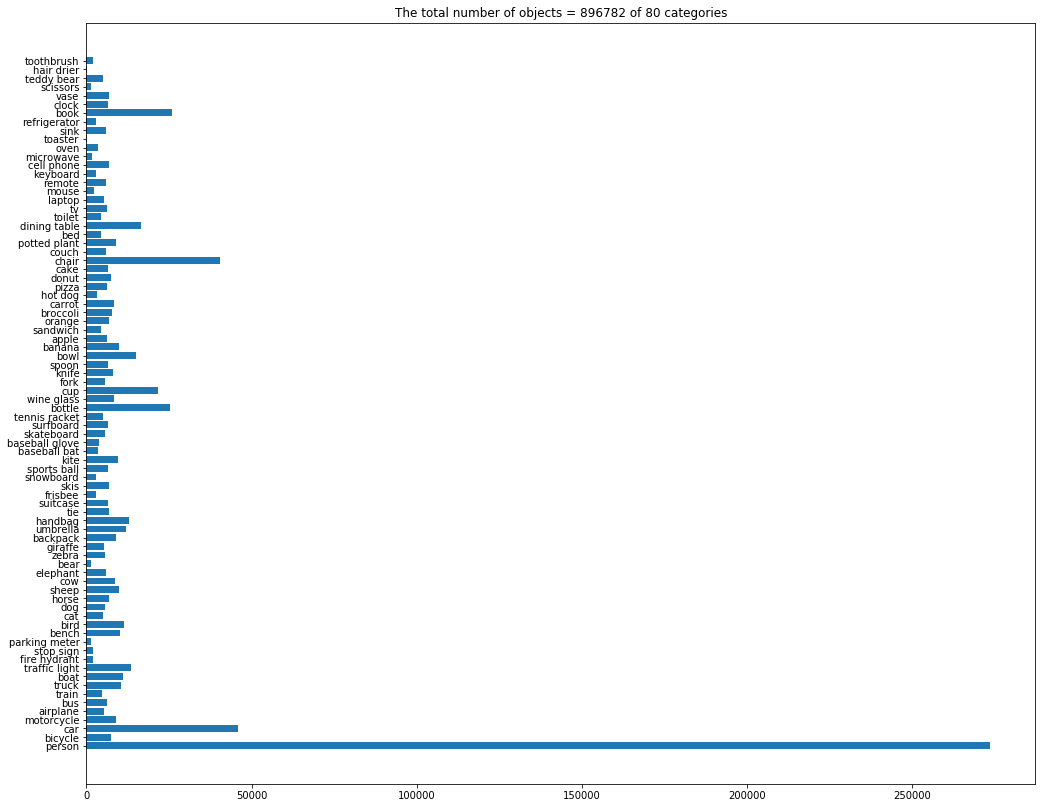

In [13]:
y_pos = np.arange(len(CAT))
fig = plt.figure(figsize=(17,14))
ax = fig.add_subplot(1,1,1)
ax.barh(y_pos,list(CAT.values()))
ax.set_yticks(y_pos)
ax.set_yticklabels(list(CAT.keys()))
ax.set_title("The total number of objects = {} of {} categories".format(
    np.sum(list(CAT.values())),len(CAT)
))
plt.show()

In [14]:
label_pth = 'E:\data\coco\labels'

In [17]:
os.listdir(label_pth)

['train2014', 'val2014']

In [129]:
wh = []
for pth in os.listdir(label_pth):
    p = os.path.join(label_pth, pth)
    #print(p)
    for txt in os.listdir(p):
        txt_path = os.path.join(label_pth, pth, txt)
        cor = np.loadtxt(txt_path)
        cor = np.asmatrix(cor)
        l = cor.shape[0]
        for i in range(l):
            a = np.array(cor[i])[0]
            wh.append(list(a[3:]))

In [131]:
len(wh)

902435

In [132]:
wh[:5]

[[0.955609, 0.5955],
 [0.498875, 0.476417],
 [0.494125, 0.510583],
 [0.678875, 0.7815],
 [0.118047, 0.096937]]

In [ ]:
wh = np.array(wh)

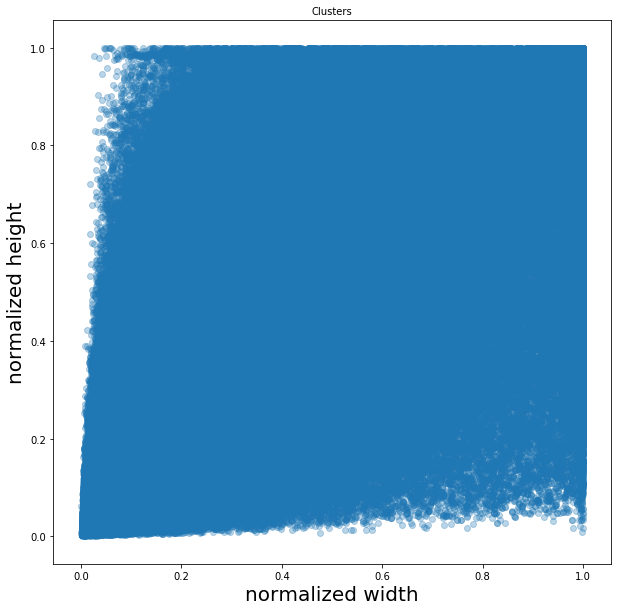

In [138]:
plt.figure(figsize=(10,10))
plt.scatter(wh[:,0],wh[:,1],alpha=0.3)
plt.title("Clusters",fontsize=20)
plt.xlabel("normalized width",fontsize=20)
plt.ylabel("normalized height",fontsize=20)
plt.show()

In [139]:
def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2) 
    '''
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

In [141]:
def kmeans(boxes, k, dist=np.median,seed=1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)] # k*2, random pick k clusters from boxex

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k): # I made change to lars76's code here to make the code faster
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters,nearest_clusters,distances

In [142]:
kmax = 10
dist = np.mean
results = {}

for k in range(2,kmax):
    clusters, nearest_clusters, distances = kmeans(wh,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.3630
 3 clusters: mean IoU = 0.4343
 4 clusters: mean IoU = 0.4715
 5 clusters: mean IoU = 0.4935
 6 clusters: mean IoU = 0.5188
 7 clusters: mean IoU = 0.5382
 8 clusters: mean IoU = 0.5543
 9 clusters: mean IoU = 0.5697


#### Visualization of k-means results

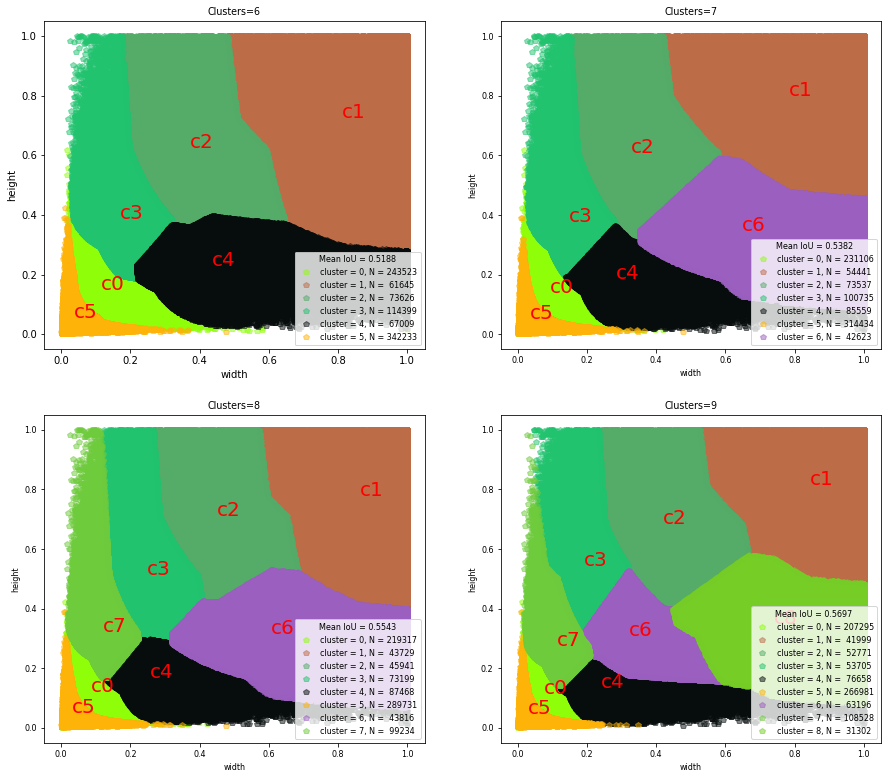

In [144]:
def plot_cluster_result(plt,clusters,nearest_clusters,WithinClusterSumDist,wh,k):
    for icluster in np.unique(nearest_clusters):
        pick = nearest_clusters==icluster
        c = current_palette[icluster]
        plt.rc('font', size=8) 
        plt.plot(wh[pick,0],wh[pick,1],"p",
                 color=c,
                 alpha=0.5,label="cluster = {}, N = {:6.0f}".format(icluster,np.sum(pick)))
        plt.text(clusters[icluster,0],
                 clusters[icluster,1],
                 "c{}".format(icluster),
                 fontsize=20,color="red")
        plt.title("Clusters=%d" %k)
        plt.xlabel("width")
        plt.ylabel("height")
    plt.legend(title="Mean IoU = {:5.4f}".format(WithinClusterSumDist))  
    
import seaborn as sns
current_palette = list(sns.xkcd_rgb.values())

figsize = (15,35)
count =1 
fig = plt.figure(figsize=figsize)
for k in range(6,10):
    result               = results[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,wh,k)
    count += 1
plt.show()

In [145]:
results

{2: {'clusters': array([[0.07141006, 0.1031515 ],
         [0.41878065, 0.4889382 ]]),
  'nearest_clusters': array([1, 1, 1, ..., 1, 1, 0], dtype=int64),
  'distances': array([[0.98705587, 0.64018557],
         [0.96900755, 0.17867047],
         [0.97080344, 0.18840867],
         ...,
         [0.97239458, 0.23263844],
         [0.93288806, 0.4639633 ],
         [0.26376649, 0.96426392]]),
  'WithinClusterMeanDist': 0.6369914682936083},
 3: {'clusters': array([[0.05201446, 0.07603309],
         [0.6163325 , 0.64247384],
         [0.20092062, 0.28702187]]),
  'nearest_clusters': array([1, 1, 1, ..., 1, 2, 0], dtype=int64),
  'distances': array([[0.99305032, 0.38626124, 0.8986608 ],
         [0.98336021, 0.39978275, 0.75736106],
         [0.98432442, 0.36286324, 0.77142101],
         ...,
         [0.9851787 , 0.32613948, 0.78387801],
         [0.96396773, 0.72281828, 0.47458268],
         [0.45952049, 0.98152106, 0.87311567]]),
  'WithinClusterMeanDist': 0.565661846087862},
 4: {'cluste

In [146]:
results[9]

{'clusters': array([[0.07675694, 0.11235531],
        [0.8431164 , 0.81456494],
        [0.42016042, 0.68507856],
        [0.19119489, 0.54369381],
        [0.23939678, 0.13323629],
        [0.03017613, 0.04651494],
        [0.32119038, 0.30944813],
        [0.11317775, 0.27465642],
        [0.74036961, 0.34964449]]),
 'nearest_clusters': array([1, 2, 2, ..., 2, 6, 0], dtype=int64),
 'distances': array([[0.98484523, 0.33390706, 0.58759768, ..., 0.82534204, 0.94537533,
         0.54510279],
        [0.96371457, 0.65392858, 0.38473845, ..., 0.58181217, 0.86921082,
         0.45847999],
        [0.96581717, 0.63264164, 0.34115009, ..., 0.60604447, 0.87678953,
         0.48944077],
        ...,
        [0.96768005, 0.61146756, 0.36570316, ..., 0.62751409, 0.8835042 ,
         0.47007698],
        [0.92142649, 0.84018341, 0.61868878, ..., 0.11456089, 0.71678535,
         0.57600589],
        [0.27638939, 0.98934547, 0.97457904, ..., 0.92637978, 0.7646053 ,
         0.97173349]]),
 'WithinCl

In [153]:
results[9]['clusters']

array([[0.07675694, 0.11235531],
       [0.8431164 , 0.81456494],
       [0.42016042, 0.68507856],
       [0.19119489, 0.54369381],
       [0.23939678, 0.13323629],
       [0.03017613, 0.04651494],
       [0.32119038, 0.30944813],
       [0.11317775, 0.27465642],
       [0.74036961, 0.34964449]])

In [164]:
proi = results[9]['clusters']*416
proi = proi.astype('int').tolist()
proi = sorted(proi, key=lambda x: x[0] * x[1])
proi

[[12, 19],
 [31, 46],
 [47, 114],
 [99, 55],
 [133, 128],
 [79, 226],
 [307, 145],
 [174, 284],
 [350, 338]]

In [165]:
### YOLOv3 paper: anchors: 10*13, 16*30, 33*23, 30*61, 62*45, 59*119, 116*90, 156*198, 373*326